# 02 - Training with Explicit Autograd Loop

This notebook demonstrates gradient-based optimization using:
- `program.expvals(thetas)` as model output
- standard PyTorch loss/backward/optimizer step

Why explicit loop:
- easier debugging of `requires_grad`, gradient norms, and training stability
- no hidden training helper logic


In [1]:
from pathlib import Path
import sys
import torch

root = Path.cwd()
if not (root / "src").exists():
    root = root.parent
sys.path.insert(0, str(root))

from src.pauli_surrogate_python import PauliRotation, CliffordGate, PauliSum
from src_tensor.api import compile_expval_program

In [2]:
n_qubits = 3

# Rotation + CNOT-ladder circuit (0->1->2 repeated)
circuit = [

    # Layer 0: local rotations
    PauliRotation("Z", [0], param_idx=0),
    PauliRotation("Z", [1], param_idx=1),
    PauliRotation("Z", [2], param_idx=2),
    PauliRotation("X", [0], param_idx=3),
    PauliRotation("X", [1], param_idx=4),
    PauliRotation("X", [2], param_idx=5),
    # CNOT ladder
    CliffordGate("CNOT", [0, 1]),
    CliffordGate("CNOT", [1, 2]),

    # Layer 1: local rotations
    PauliRotation("Z", [0], param_idx=6),
    PauliRotation("Z", [1], param_idx=7),
    PauliRotation("Z", [2], param_idx=8),
    PauliRotation("Y", [0], param_idx=9),
    PauliRotation("Y", [1], param_idx=10),
    PauliRotation("Y", [2], param_idx=11),
    # CNOT ladder (reverse)
    CliffordGate("CNOT", [1, 2]),
    CliffordGate("CNOT", [0, 1]),

    # Layer 2: final rotations
    PauliRotation("X", [0], param_idx=12),
    PauliRotation("Y", [1], param_idx=13),
    PauliRotation("Z", [2], param_idx=14),
]

obs = []
for q in range(n_qubits):
    o = PauliSum(n_qubits)
    o.add_from_str("Z", 1.0, qubits=[q])
    obs.append(o)

# IMPORTANT: build-time theta pruning (build_min_abs) can remove parameter paths
# and make pred non-differentiable away from build_thetas. Keep it OFF for training.
thetas = torch.nn.Parameter(torch.randn(15, dtype=torch.float32, device='cuda'))
program = compile_expval_program(circuit=circuit, observables=obs, preset="gpu_min",build_thetas=thetas,build_min_abs=1e-2,build_min_mat_abs=1e-2)


propagate: 100%|██████████| 19/19 [00:01<00:00, 14.49it/s]


## Optimize parameters against target expectations

Key tensors:
- `thetas`: trainable circuit parameters
- `target`: desired expectation vector
- `pred`: model prediction from compiled surrogate
- `loss`: distance between `pred` and `target`

`pred.requires_grad` must be `True`; otherwise parameter paths were likely pruned too aggressively at build time.


In [3]:
# Trainable parameters (must match max param_idx + 1 from the circuit above)


optimizer = torch.optim.Adam([thetas], lr=0.01)

target = torch.tensor([0.2, -0.1, 0.5], dtype=torch.float32, device='cuda')

final loss: 7.845576605373071e-15
final grad_norm: 9.098061326540119e-08
final thetas: tensor([-0.5307, -1.1299,  0.5881,  0.9825,  0.0449, -0.2901,  0.3541, -0.3645,
         1.2743, -1.3918,  0.3032, -0.7320, -1.2163, -0.8852,  0.8763])
pred: tensor([ 0.2000, -0.1000,  0.5000])


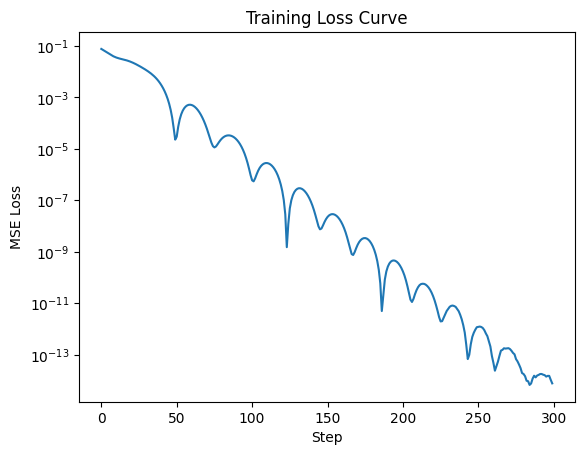

In [4]:
num_steps = 300
history = []

for step in range(num_steps):
    optimizer.zero_grad(set_to_none=True)

    pred = program.expvals(thetas)
    loss_t = torch.mean((pred - target) ** 2)

    if not bool(pred.requires_grad):
        raise RuntimeError(
            "pred does not require gradients. If you compiled with build_min_abs, recompile without build_min_abs (or use a much smaller threshold)."
        )

    loss_t.backward()
    if thetas.grad is None:
        raise RuntimeError("No gradient on thetas after backward().")

    grad_norm = torch.linalg.vector_norm(thetas.grad.detach())
    optimizer.step()

    history.append(float(loss_t.detach().cpu().item()))

print("final loss:", history[-1])
print("final grad_norm:", float(grad_norm.detach().cpu().item()))
print("final thetas:", thetas.detach().cpu())
print("pred:", pred.detach().cpu())

from matplotlib import pyplot as plt
plt.plot(history)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()


In [5]:
# Build-time pruning sweep: build_min_abs / build_min_mat_abs vs size/speed
import time
from src_tensor.api import compile_expval_program

def _step_nnz(psum):
    total = 0
    for st in psum.steps:
        total += int(st.mat_const._nnz()) + int(st.mat_cos._nnz()) + int(st.mat_sin._nnz())
    return total

def _time_eval(prog, th, runs=50):
    _ = prog.expvals(th, stream_device='cpu', offload_back=False)
    t0 = time.perf_counter()
    for _ in range(runs):
        _ = prog.expvals(th, stream_device='cpu', offload_back=False)
    return (time.perf_counter() - t0) / runs

theta_build = thetas.detach().cpu().to(torch.float32)
theta_train = torch.nn.Parameter(theta_build.clone())
target_cpu = target.detach().cpu().to(torch.float32)

configs = [
    (None, None),
    (1e-7, None),
    (1e-6, None),
    (1e-6, 1e-8),
    (1e-5, 1e-7),
]

rows = []
for b_abs, b_mat in configs:
    t0 = time.perf_counter()
    prog = compile_expval_program(
        circuit=circuit,
        observables=obs,
        preset='gpu_min',
        preset_overrides={
            'build_device': 'cpu',
            'step_device': 'cpu',
            'stream_device': 'cpu',
            'dtype': 'float32',
            'offload_steps': False,
            'offload_back': False,
            'max_weight': 1_000_000_000,
            'max_xy': 1_000_000_000,
        },
        build_thetas=theta_build,
        build_min_abs=b_abs,
        build_min_mat_abs=b_mat,
    )
    compile_s = time.perf_counter() - t0

    nnz = _step_nnz(prog.psum_union)
    eval_ms = 1e3 * _time_eval(prog, theta_build, runs=50)

    # one-step grad sanity
    th = torch.nn.Parameter(theta_train.detach().clone())
    pred = prog.expvals(th, stream_device='cpu', offload_back=False)
    loss = torch.mean((pred - target_cpu) ** 2)
    loss.backward()
    grad_ok = th.grad is not None and bool(pred.requires_grad)

    rows.append((b_abs, b_mat, compile_s, nnz, eval_ms, float(loss.detach()), grad_ok))

print('build_min_abs | build_min_mat_abs | compile(s) | total_nnz | eval(ms) | loss | grad_ok')
for r in rows:
    print(f'{str(r[0]):>12} | {str(r[1]):>17} | {r[2]:9.3f} | {r[3]:9d} | {r[4]:8.3f} | {r[5]:.3e} | {r[6]}')


propagate: 100%|██████████| 19/19 [00:00<00:00, 306.10it/s]


build_min_abs | build_min_mat_abs | compile(s) | total_nnz | eval(ms) | loss | grad_ok
        None |              None |     0.666 |       169 |    1.691 | 7.677e-07 | True
       1e-07 |              None |     0.652 |       169 |    1.732 | 7.677e-07 | True
       1e-06 |              None |     0.806 |       169 |    1.625 | 7.677e-07 | True
       1e-06 |             1e-08 |     0.074 |       169 |    1.606 | 7.677e-07 | True
       1e-05 |             1e-07 |     0.074 |       169 |    1.629 | 7.677e-07 | True


## Why this sweep matters
- `build_min_abs`: compile-time theta-dependent path pruning
- `build_min_mat_abs`: compile-time sparse entry pruning by `|M_ij|`

The sweep reports compile time, nnz, eval latency, loss level, and gradient availability.
Use it to choose pruning that still preserves trainability.
